# Data mining techniques: Assignment 2

## Exploratory Data Analysis

In [1]:
library("compiler")
library("ggplot2")
library("grid")
library("gridExtra")
library("scales")
library("plyr")
library("corrplot")
library("gbm")
library("xgboost")

Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”Warning message:
“package ‘scales’ was built under R version 3.4.4”Warning message:
“package ‘plyr’ was built under R version 3.4.4”Warning message:
“package ‘corrplot’ was built under R version 3.4.4”corrplot 0.84 loaded
Warning message:
“package ‘gbm’ was built under R version 3.4.4”Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3


# Load the data

In [3]:
# Memory efficient column specific data frame loading functions
convert_to_numeric <- function(df){
    factor_cols <- unlist(lapply(df, is.factor))
    factor_cols["date_time"] <- FALSE

    for (name in colnames(df[factor_cols])){
        df[name] <- as.numeric(sub('NULL',NA,as.character(df[name][,1])))
    }
    
    return(df)
}

col_list <- function(names,selected,df){
    res <- c(1:length(names))
    res[] <- "NULL"
        
    for(i in 1:length(selected)){
        res[names == selected[i]] <- df[selected[i],1]
    }
    
    return(res)
}

load_part <- function(path,nrows = -1,skip = 1,colClasses = NA){
    namecols <- colClasses
    if(length(namecols) > 1 || !is.na(namecols)){
        namecols[colClasses != "NULL"] <- NA
    }
    
    names <- colnames(read.csv(trainPath,nrows = 1,colClasses=namecols))
    df <- read.csv(trainPath,header=F,skip=skip,nrows = nrows,colClasses=colClasses,
                   na.strings=c("NA","NULL"))
    
    colnames(df) <- names
    
    return(df)
}

In [4]:
trainPath <- "/home/kevin/data_mining/data/assignment2/train.csv"
testPath <- "/home/kevin/data_mining/data/assignment2/test.csv"

trainNames <- colnames(read.csv(trainPath,nrows = 1))
testNames <- colnames(read.csv(testPath,nrows = 1))

# Initialize types to numeric
traintypes <- c(1:length(trainNames))
traintypes[] <- "numeric"

# Initialize type dataframe
train.types <- data.frame(types=traintypes,stringsAsFactors=FALSE)
rownames(train.types) <- trainNames

# Set types manually
train.types["date_time","types"] <- "character"

train.types

,types
srch_id,numeric
date_time,character
site_id,numeric
visitor_location_country_id,numeric
visitor_hist_starrating,numeric
visitor_hist_adr_usd,numeric
prop_country_id,numeric
prop_id,numeric
prop_starrating,numeric
prop_review_score,numeric


In [5]:
# Example
attributes <- c("srch_id","comp1_rate")
columns <- col_list(trainNames,attributes,train.types)
load_part(trainPath,nrows = 5,colClasses = columns)

srch_id,comp1_rate
1,NA
1,NA
1,NA
1,NA
1,NA


# Initial data exploration

## Plot missing values

In [176]:
attributes <- trainNames
columns <- col_list(trainNames,attributes,train.types)
df <- load_part(trainPath,colClasses = columns)

# Get NA value booleans
nas <- is.na(df)

len.nas <- length(nas[,1])

# Initialize NA vector
na.vec <- vector(mode="integer",length=length(colnames(df)))

# Sum the NA values and fill NA vector
for (i in 1:length(na.vec)){
    na.vec[i] <- sum(nas[,i]) / len.nas
}

# Create bar plot Data Frame
na.df <- data.frame(colnames(df),na.vec)
colnames(na.df) <- c("attribute","missing_values")

# Sort by number of missing values
position <- arrange(na.df,missing_values)["attribute"][,1]

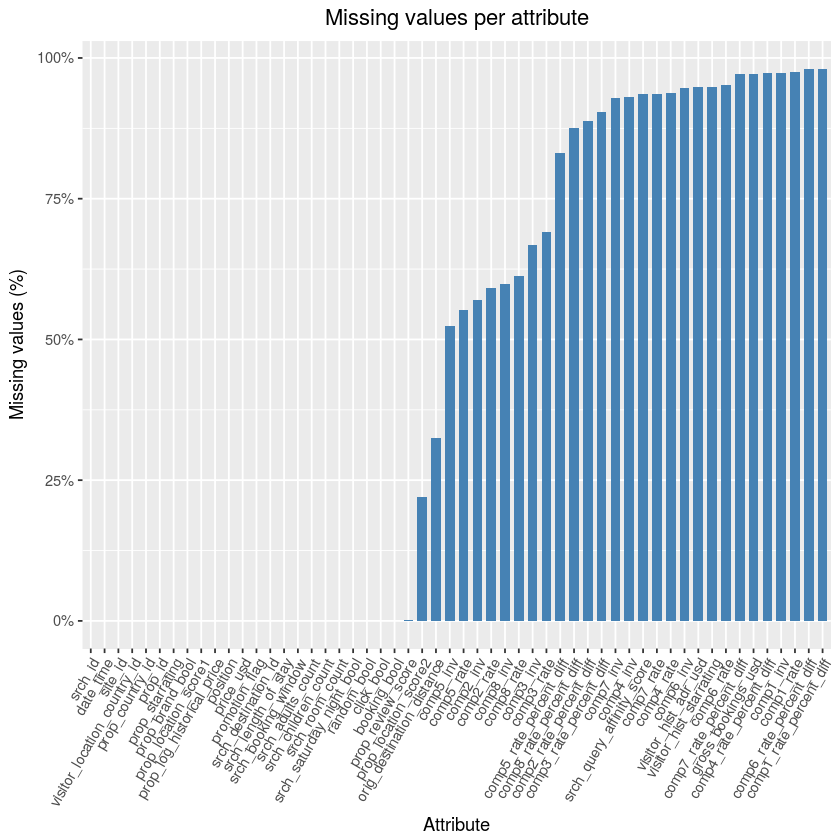

In [177]:
# Plot missing values bar plot
ggplot(data=na.df,aes(x=factor(attribute),y=missing_values)) + 
geom_bar(stat="identity",width=0.7, fill="steelblue") +
theme(axis.text.x = element_text(angle = 60, hjust = 1), plot.title = element_text(hjust = 0.5)) + 
scale_x_discrete(limits=position) + scale_y_continuous(labels=percent) +
labs(title="Missing values per attribute", x="Attribute", y="Missing values (%)")

## Data summaries

In [178]:
summary(df)

    srch_id                     date_time          site_id      
 Min.   :     1   2012-11-02 14:04:51:     95   Min.   : 1.000  
 1st Qu.: 82936   2012-12-26 10:59:30:     87   1st Qu.: 5.000  
 Median :166507   2013-05-15 18:39:51:     70   Median : 5.000  
 Mean   :166367   2012-11-23 07:28:55:     69   Mean   : 9.953  
 3rd Qu.:249724   2012-12-03 10:33:44:     68   3rd Qu.:14.000  
 Max.   :332785   2012-12-26 14:26:28:     68   Max.   :34.000  
                  (Other)            :4957890                   
 visitor_location_country_id visitor_hist_starrating visitor_hist_adr_usd
 Min.   :  1.0               Min.   :1               Min.   :   0        
 1st Qu.:100.0               1st Qu.:3               1st Qu.: 110        
 Median :219.0               Median :3               Median : 152        
 Mean   :175.3               Mean   :3               Mean   : 176        
 3rd Qu.:219.0               3rd Qu.:4               3rd Qu.: 213        
 Max.   :231.0               Max.   

# Exploratory data analysis: Investigate Missing Values

## Competitor attributes

In [180]:
comp_data <- function(df,attr_name){
    
    booked <- df[,"booking_bool"] == 1
    clicked <- df[,"click_bool"] == 1

    books <- data.frame()
    clicks <- data.frame()

    for (i in c(1:8)){
        str <- sprintf("comp%i_%s",i,attr_name)
        
        # Full value counts
        full <- as.data.frame(table(df[,str], useNA="always"))
    
        full[,"Competitor"] <- factor(i,levels=c(1:8))
    
        full[,"Var1"] <- factor(full[,"Var1"],levels=c(-1,0,1,"NA"))
        full[is.na(full[,"Var1"]),"Var1"] <- factor("NA",levels=c(-1,0,1,"NA"))
    
        # Booked value counts
        book <- as.data.frame(table(df[booked,str], useNA="always"))
    
        book[,"Competitor"] <- factor(i,levels=c(1:8))
    
        book[,"Var1"] <- factor(book[,"Var1"],levels=c(-1,0,1,"NA"))
        book[is.na(book[,"Var1"]),"Var1"] <- factor("NA",levels=c(-1,0,1,"NA"))
    
        book[,"Freq"] <- book[,"Freq"] / full[,"Freq"]
    
        # Click value counts
        click <- as.data.frame(table(df[clicked,str], useNA="always"))
        
        click[,"Competitor"] <- factor(i,levels=c(1:8))
    
        click[,"Var1"] <- factor(click[,"Var1"],levels=c(-1,0,1,"NA"))
        click[is.na(click[,"Var1"]),"Var1"] <- factor("NA",levels=c(-1,0,1,"NA"))
    
        click[,"Freq"] <- click[,"Freq"] / full[,"Freq"]
    
        books <- rbind(books,book)
        clicks <- rbind(clicks,click)
    }
    
    return(list(books,clicks))
}

### Competitor rates

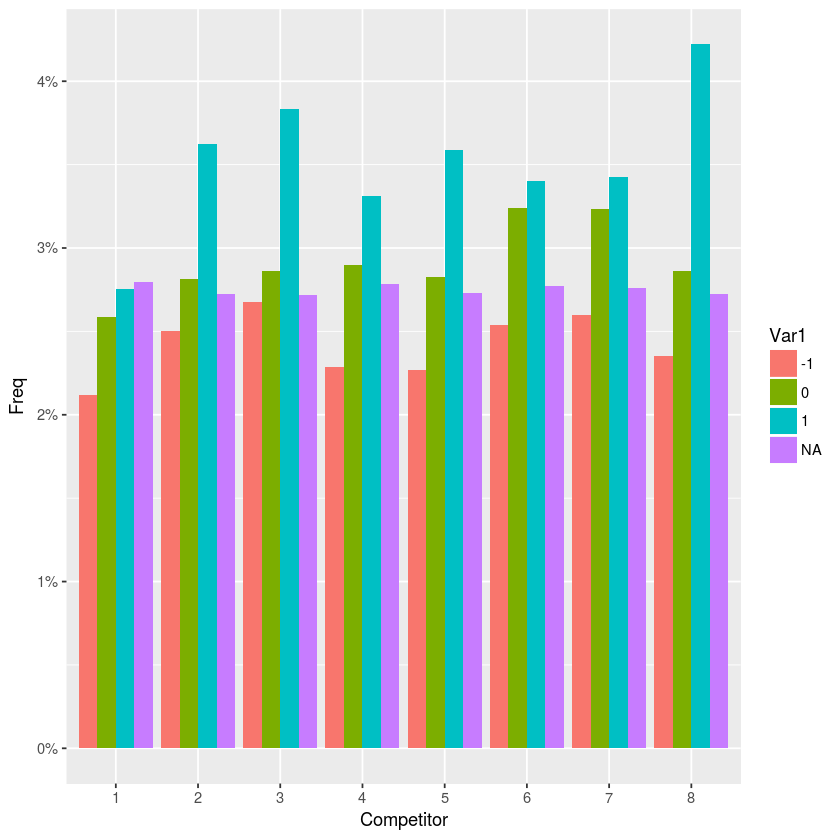

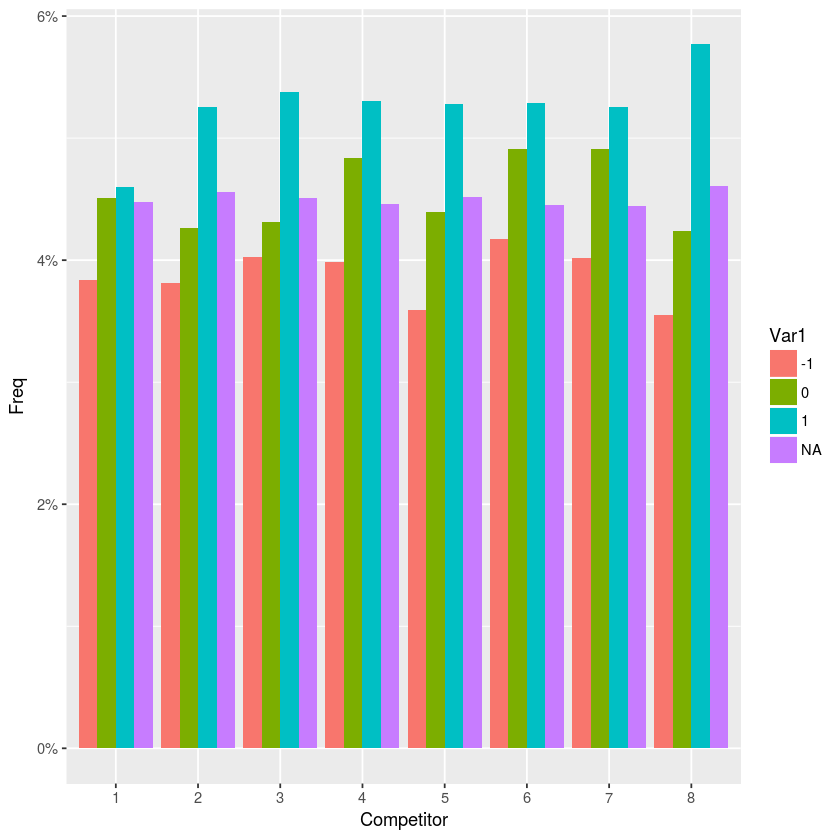

In [181]:
attributes <- c(sprintf("comp%i_rate",1:8),"booking_bool","click_bool")
columns <- col_list(trainNames,attributes,train.types)
df <- load_part(trainPath,colClasses = columns)

data <- comp_data(train,"rate")

books <- data[[1]]
clicks <- data[[2]]

ggplot(data=books, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent)

ggplot(data=clicks, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent)

### Competitor inv

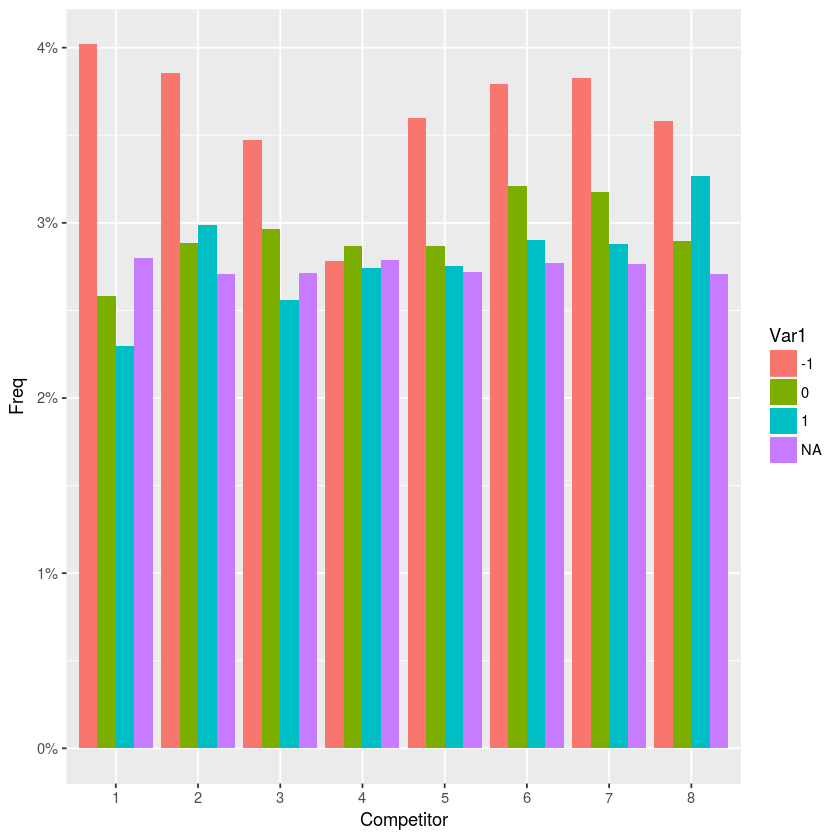

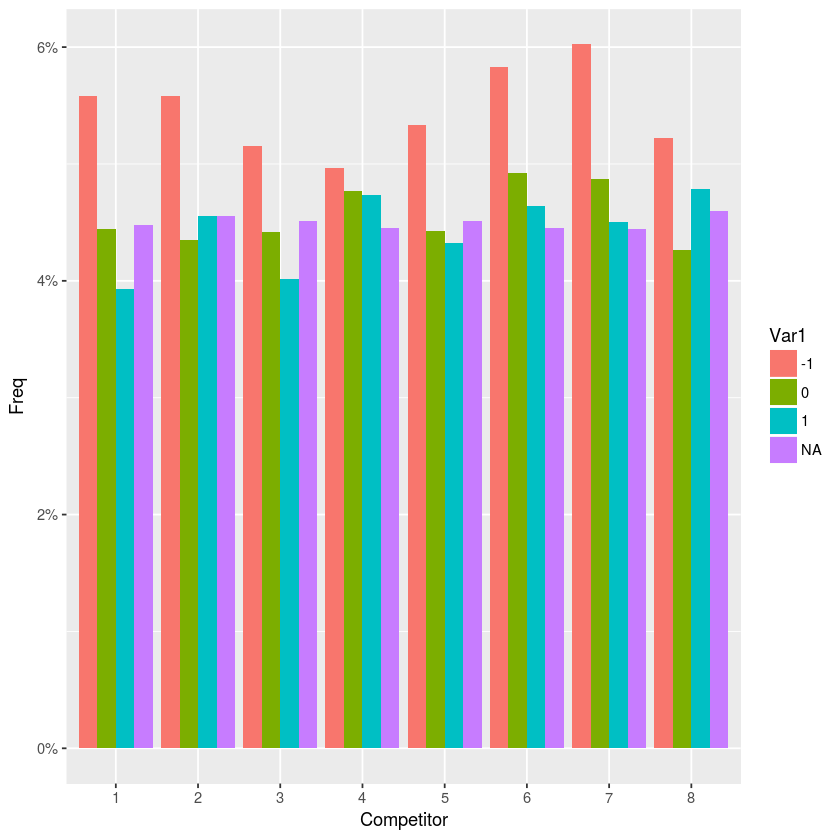

In [182]:
attributes <- c(sprintf("comp%i_inv",1:8),"booking_bool","click_bool")
columns <- col_list(trainNames,attributes,train.types)
df <- load_part(trainPath,colClasses = columns)

data <- comp_data(train,"inv")

books <- data[[1]]
clicks <- data[[2]]

ggplot(data=books, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent)

ggplot(data=clicks, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent)

## Descriptive hotel attributes (description for customers)

In [183]:
na_booking_data <- function(df,attr_name){
    booked <- df[,"booking_bool"] == 1
    clicked <- df[,"click_bool"] == 1
    
    nas.full <- is.na(df[,attr_name])
    nas.book <- nas.full[booked]
    nas.click <- nas.full[clicked]
    
    labels <- c("Not NA","NA")
    
    book.ratio.na <- sum(nas.book) / sum(nas.full)
    book.ratio.nna <- sum(!nas.book) / sum(!nas.full)
    
    click.ratio.na <- sum(nas.click) / sum(nas.full)
    click.ratio.nna <- sum(!nas.click) / sum(!nas.full)
    
    # Booked value counts
    books <- data.frame(target_attribute="booking_bool",attribute=attr_name,var=labels,
                        ratio = c(book.ratio.nna,book.ratio.na))

    # Click value counts
    clicks <- data.frame(target_attribute="click_bool",attribute=attr_name,var=labels,
                        ratio = c(click.ratio.nna,click.ratio.na))
    
    result <- rbind(books,clicks)
    return(result)
}

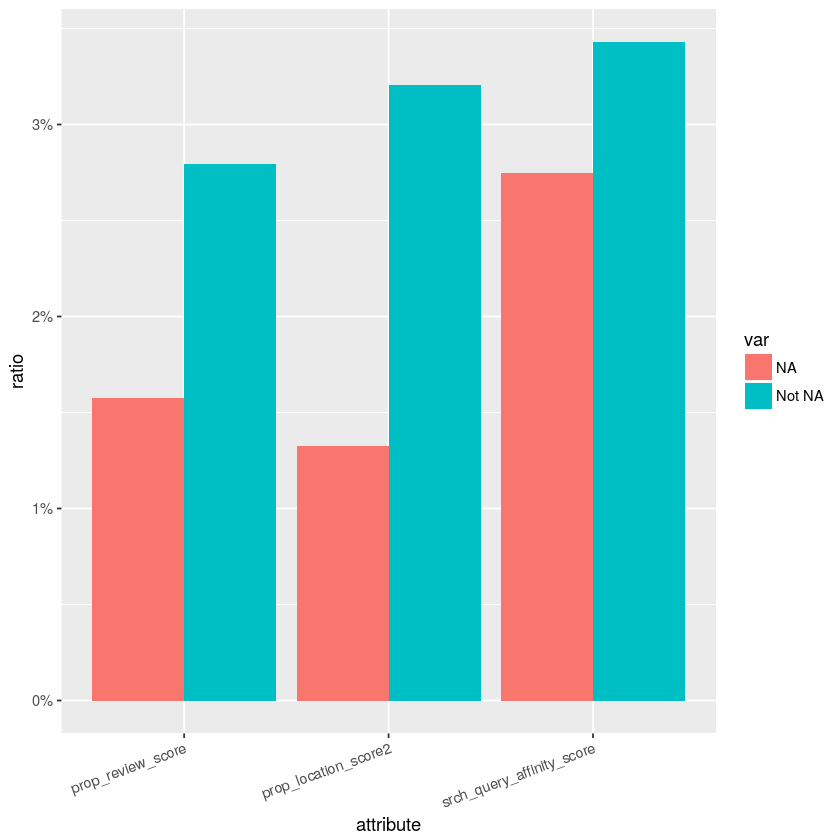

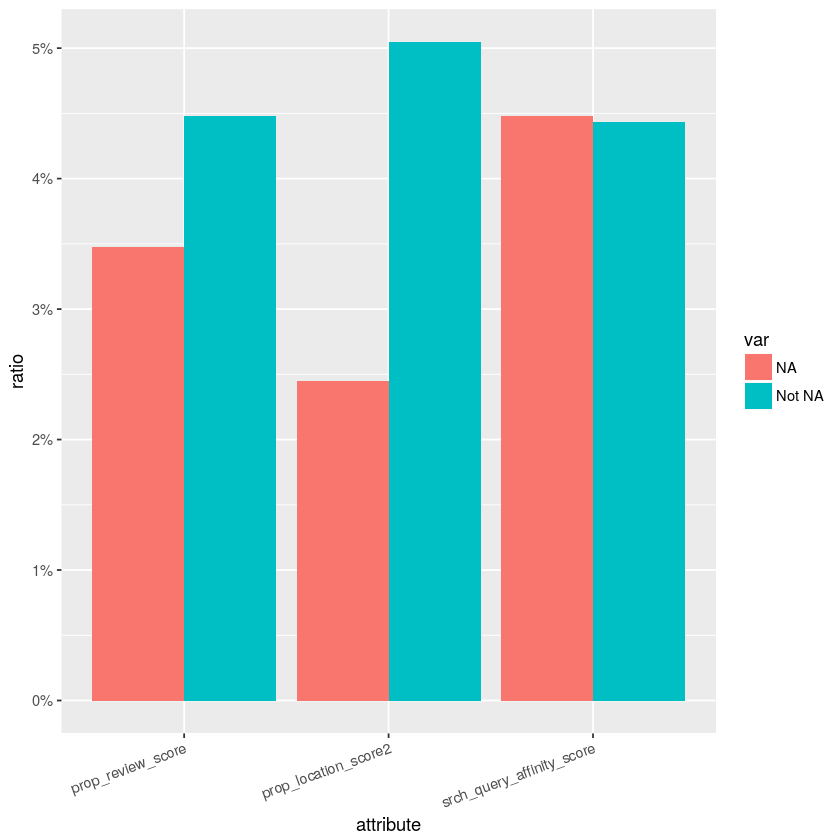

In [184]:
attributes <- c("prop_review_score","prop_location_score2",
                "srch_query_affinity_score","booking_bool","click_bool")
columns <- col_list(trainNames,attributes,train.types)
df <- load_part(trainPath,colClasses = columns)

hotel.df <- rbind(na_booking_data(df,"prop_review_score"),
                  na_booking_data(df,"prop_location_score2"),
                  na_booking_data(df,"srch_query_affinity_score"))

books <- hotel.df[hotel.df[,"target_attribute"] == "booking_bool",]
clicks <- hotel.df[hotel.df[,"target_attribute"] == "click_bool",]

ggplot(data=books, aes(x=attribute,y=ratio,fill=var)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(axis.text.x = element_text(angle = 20, hjust = 1), plot.title = element_text(hjust = 0.5))

ggplot(data=clicks, aes(x=attribute,y=ratio,fill=var)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(axis.text.x = element_text(angle = 20, hjust = 1), plot.title = element_text(hjust = 0.5))

## Origin-destination distance

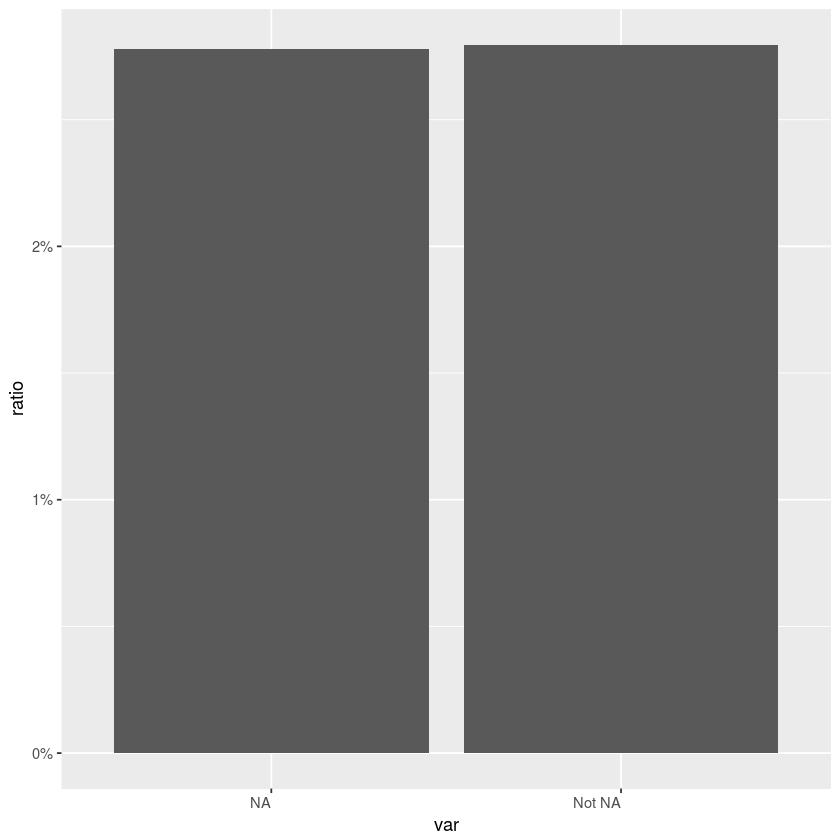

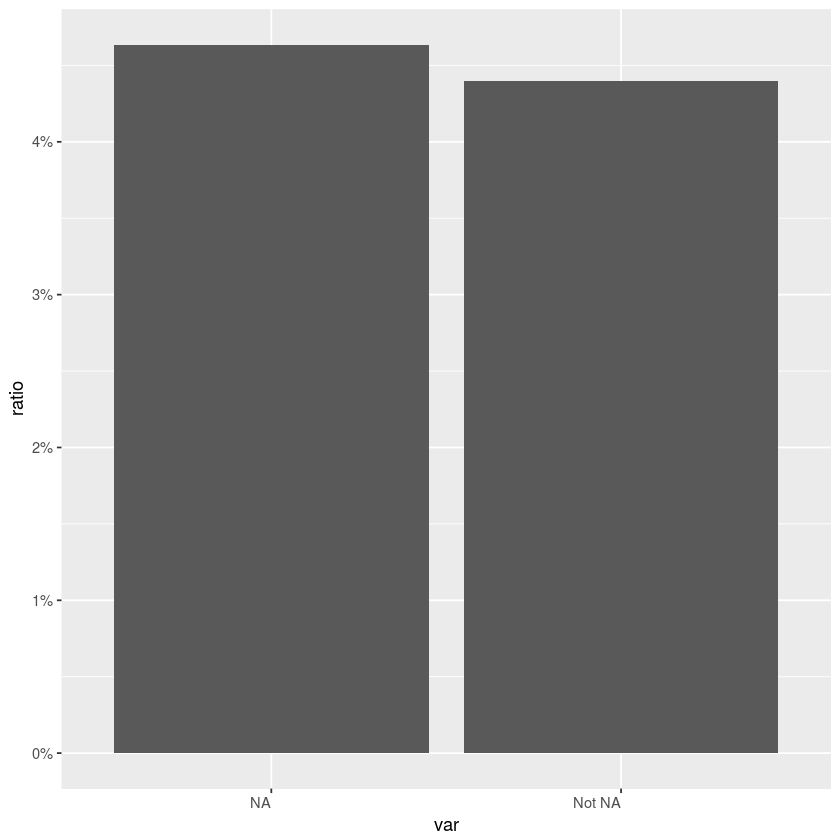

In [185]:
attributes <- c("orig_destination_distance","booking_bool","click_bool")
columns <- col_list(trainNames,attributes,train.types)
df <- load_part(trainPath,colClasses = columns)

distance.df <- na_booking_data(df,"orig_destination_distance")

books <- distance.df[distance.df[,"target_attribute"] == "booking_bool",]
clicks <- distance.df[distance.df[,"target_attribute"] == "click_bool",]

ggplot(data=books, aes(x=var,y=ratio)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(axis.text.x = element_text(angle = 0, hjust = 1), plot.title = element_text(hjust = 0.5))

ggplot(data=clicks, aes(x=var,y=ratio)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(axis.text.x = element_text(angle = 0, hjust = 1), plot.title = element_text(hjust = 0.5))

Warning message:
“Removed 1607782 rows containing non-finite values (stat_bin).”

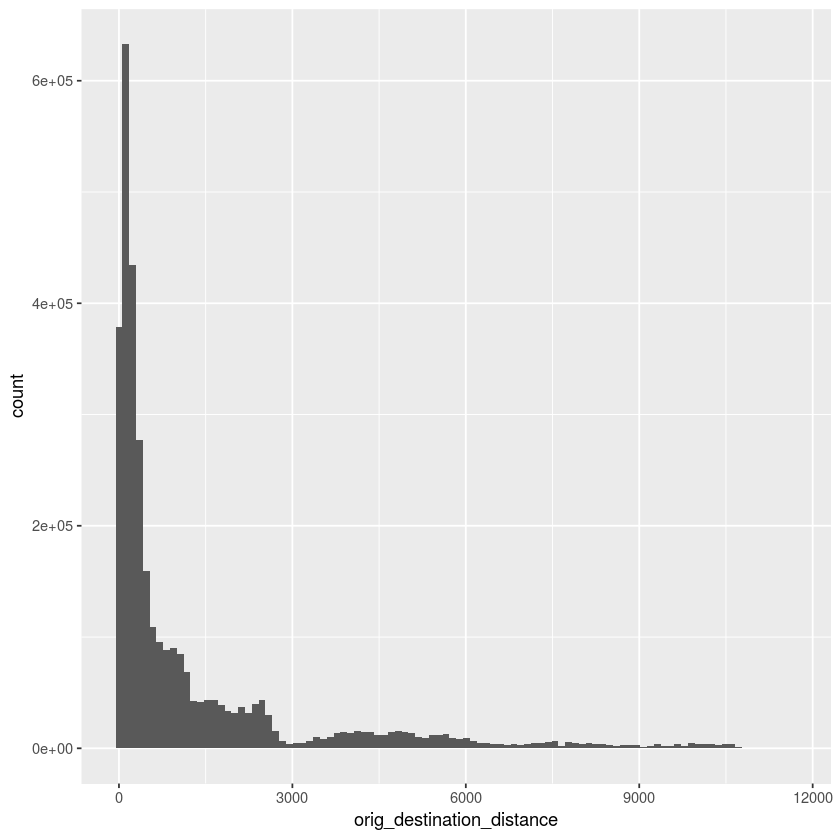

In [186]:
ggplot(data=df, aes(x=orig_destination_distance, na.rm=TRUE)) +
geom_bar(stat="bin",bins=100) + theme(plot.title = element_text(hjust = 0.5))

# Exploratory data analysis: Feature Relations

# Feature extraction and Engineering

## Extract time features from date_time

In [166]:
attributes <- c("date_time")
columns <- col_list(trainNames,attributes,train.types)
df <- load_part(trainPath,colClasses = columns)

date <- strptime(df[,"date_time"],format="%Y-%m-%d %H:%M:%OS")

date.df <- data.frame(year=as.numeric(format(date,format="%Y")),month=as.numeric(format(date,format="%m")),
                      day=as.numeric(format(date,format="%d")),hour=as.numeric(format(date,format="%H")),
                      minute=as.numeric(format(date,format="%M")),second=as.numeric(format(date,format="%OS")))

colnames(date.df) = paste("date_",colnames(date.df),sep="")

head(date.df)

date_year,date_month,date_day,date_hour,date_minute,date_second
2013,4,4,8,32,15
2013,4,4,8,32,15
2013,4,4,8,32,15
2013,4,4,8,32,15
2013,4,4,8,32,15
2013,4,4,8,32,15


In [167]:
# Replace date_time with relevant time values

for (col in c("date_year","date_month","date_hour")){
    train[,col] <- date.df[,col]
}

num.attr <- length(colnames(train))

train <- train[,colnames(train)[c(1,(num.attr-2):num.attr,2:(num.attr-3))]]

# Exploratory data analysis: Feature Importance

## Plot something

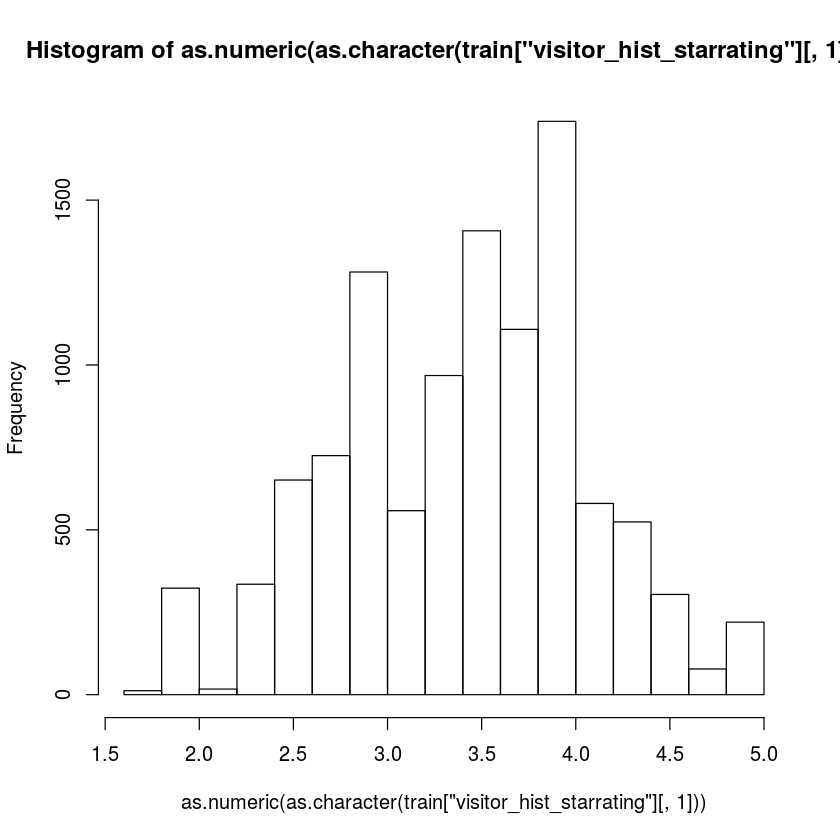

In [168]:
#ggplot(data=train,aes(x=visitor_hist_starrating)) + geom_histogram(bins=30)
hist(as.numeric(as.character(train["visitor_hist_starrating"][,1])))

# Export imputed and engineered Data frame

## Construct final data frame

## Add relevance targets

In [ ]:
relevance <- numeric(nrow(train))

booked <- train[,"booking_bool"] == 1
clicked <- !booked & (train[,"click_bool"] == 1)

relevance[booked] <- 5
relevance[clicked] <- 1

train[,"relevance"] <- relevance

## Correlation plot of the numeric attributes

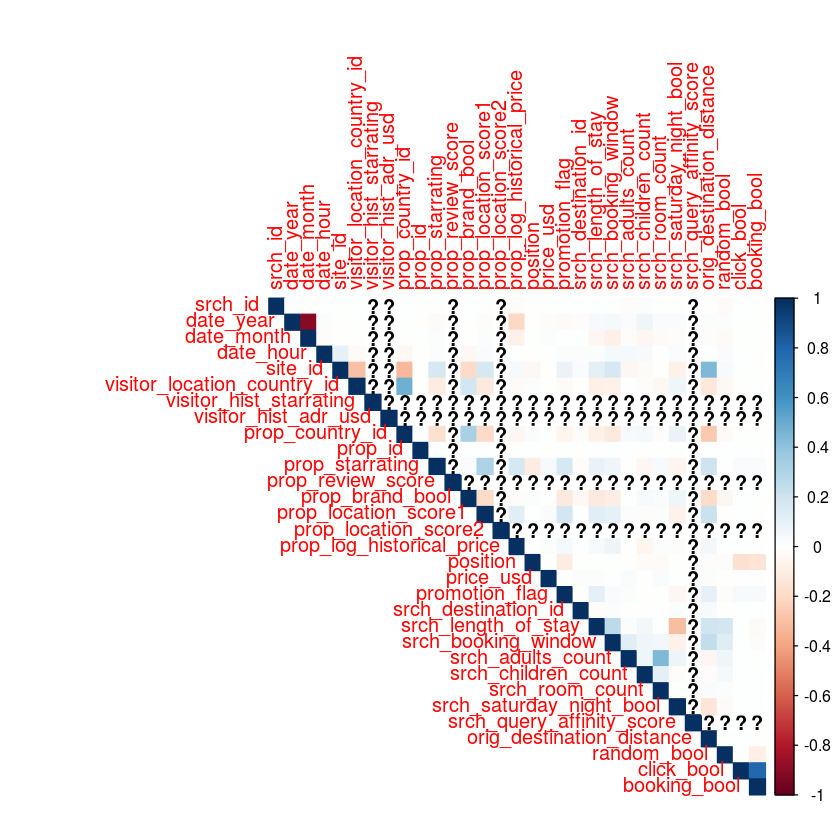

In [171]:
train.nums <- unlist(lapply(train, is.numeric))
l.idx <- length(colnames(train))

corrplot(cor(train[colnames(train)[c(1:29,l.idx-2,l.idx)]]),method="color",type="upper")